# Mini-projeto SI - Árvores de Decisão

Grupo:

- Júlio Cesar Farias da Luz - jcfl
- Matheus Rodrigues Bueno Godinho - mrbg
- Caio de Mendonça Barbosa - cmb2
- João Paulo de Albuquerque Rocha - jpar
- Mácio Meneses Monteiro Jr - mmmj
- Allan Soares Vasconcelos - asv

O objetivo deste projeto é usar aprendizado de máquina para criar um modelo que preveja quais passageiros sobreviveram ao naufrágio do Titanic.

##Introdução

In [1]:
#Imports necessários

import numpy as np
import pandas as pd
import re
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont

In [3]:
# Pegando o dataset do drive para rodar no colab
from google.colab import drive
drive.mount('/content/drive')
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/gdrive

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/gdrive


In [4]:
# Carregando os dados

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

Vamos guardar os Ids de cada passageiro, para acessá-los no futuro.

In [5]:
PassengerId = test['PassengerId']

In [6]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Podemos ver que nosso dataset precisa de tratamento. As colunas 'Name', 'Sex', 'Ticket', 'Fare', 'Cabin' e 'Embarked' precisam ser adaptadas para o problema que estamos tentando resolver, e também podemos criar alguns novos recursos combinando ou agrupando as colunas existentes. Além disso, temos NaN's nas colunas 'Age', 'Cabin' e 'Embarked', que precisarão de tratamento.


Antes de iniciar o tratamento, vamos fazer cópias dos nossos dados para não perdê-los.

In [7]:
original_train = train.copy() 
full_data = [train, test]

##Premissas e tratamento dos dados

Dando início ao nosso tratamento, partimos das seguintes premissas e optamos pelas seguintes alterações:

- Para a coluna 'Cabin', faz mais sentido que saibamos se o passageiro tinha ou não uma cabine. Dessa forma, vamos criar uma coluna 'Has_Cabin', com valores 0 ou 1.

- A coluna 'SibSp' significa número de irmãos + cônjuge de uma pessoa a bordo. A coluna 'Parch' significa número de pais + filhos de uma pessoa a bordo. A melhor forma de analisarmos influência que a quantidade de familiares a bordo tem na sobrevivência de um passageiro é unificando esses dois dados em uma única coluna, que chamaremos de 'FamilySize'.

- Faz sentido criar uma coluna para saber se o passageiro estava viajando sozinho ou não. Criaremos a coluna 'IsAlone'.

- À primeira vista, a coluna 'Name' parece não ter importância na sobrevivência de um passageiro ou não. Por outro lado, foi levantada a hipótese de que talvez pessoas com título de Don ou Dr tenham sido privilegiadas na evacuação do navio. Sendo assim, vamos extrair dos nomes os títulos de cada passageiro e criar a coluna 'Title'.

- As colunas que não são numéricas serão transformadas para colunas numéricas

In [9]:
# Característica que indica se o passageiro tinha uma cabine no Titanic.
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Criando a coluna FamilySize como uma combinação de SibSp e Parch.
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

# Criando a coluna IsAlone a partir da coluna FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

# Removendo todos os NaNs na coluna Embarked
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

# Removendo todos os NaNs na coluna Fare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

# Removendo todos os NaNs na coluna Age
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset.loc[np.isnan(dataset['Age']), 'Age'] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

# Criando função para extrair os títulos dos passageiros
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

# Agrupando todos os títulos não comuns em um único grupo chamado "Rare".
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Transformando em valores numéricos a coluna Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Transformando em valores numéricos a coluna Title
    title_mapping = {"Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    # Transformando em valores numéricos a coluna Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Transformando em valores numéricos a coluna Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Transformando em valores numéricos a coluna Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] ;

Feito isso, podemos dropar as colunas 'PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp', pois serão mais necessárias.

In [10]:
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [11]:
train.head()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,0,2,0,1
1,1,1,0,2,0,3,1,1,2,0,3
2,1,3,0,1,0,1,0,0,1,1,4
3,1,1,0,2,0,3,0,1,2,0,3
4,0,3,1,2,0,1,0,0,1,1,1


In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Survived    891 non-null    int64
 1   Pclass      891 non-null    int64
 2   Sex         891 non-null    int64
 3   Age         891 non-null    int64
 4   Parch       891 non-null    int64
 5   Fare        891 non-null    int64
 6   Embarked    891 non-null    int64
 7   Has_Cabin   891 non-null    int64
 8   FamilySize  891 non-null    int64
 9   IsAlone     891 non-null    int64
 10  Title       891 non-null    int64
dtypes: int64(11)
memory usage: 76.7 KB


Nosso dataset agora está tratado, com apenas valores numéricos e recursos potencialmente significativos. Vamos explorar a relação entre nossas variáveis ​​plotando a Correlação de Pearson entre todos os atributos em nosso conjunto de dados.

##Análise dos dados

<Axes: title={'center': 'Pearson Correlation of Features'}>

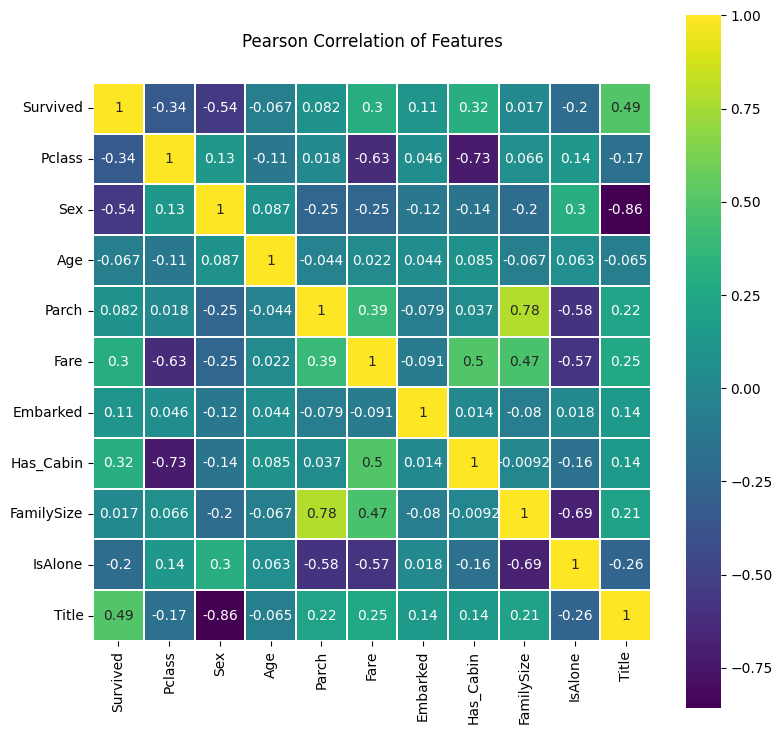

In [18]:
colormap = plt.cm.viridis
plt.figure(figsize=(9,9))
plt.title('Pearson Correlation of Features', y=1.05, size=12)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

Analisando o mapa de calor, vamos que 'Sex' e 'Title' têm as correlações mais altas (em termos absolutos) com a classe 'Survived': 0,54 e 0,49, respectivamente. Mas a correlação absoluta entre ambos também é muito alta (0,86, a mais alta em nosso conjunto de dados), então eles provavelmente estão carregando a mesma informação e usar os dois como entradas para o mesmo modelo não seria uma boa ideia. É muito provável que um deles seja usado para o primeiro nó em nossa árvore de decisão final, então vamos explorar ainda mais esses recursos e compará-los.

**Title vs Sex**

Você pode facilmente comparar características e sua relação com a classe agrupando-as e calculando algumas estatísticas básicas para cada grupo. O código abaixo faz exatamente isso em uma única linha e explica o significado de cada métrica ao trabalhar com uma classe binária.

In [19]:
train[['Title', 'Survived']].groupby(['Title'], as_index=False).agg(['mean', 'count', 'sum'])

Survived           
           mean count  sum
Title                     
1      0.156673   517   81
2      0.575000    40   23
3      0.793651   126  100
4      0.702703   185  130
5      0.347826    23    8

Como "Survived" é uma classe binária (0 ou 1), essas métricas agrupadas pela característica Título representam:

- MEAN: taxa de sobrevivência
- COUNT: observações totais
- SUM: pessoas que sobreviveram

title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5} 

In [20]:
train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).agg(['mean', 'count', 'sum'])

Survived           
         mean count  sum
Sex                     
0    0.742038   314  233
1    0.188908   577  109

Já que Sobreviveu é uma característica binária, essas métricas agrupadas pela característica Sexo representam:

- MEAN: taxa de sobrevivência
- COUNT: observações totais
- SUM: pessoas que sobreviveram

sex_mapping = {{'female': 0, 'male': 1}} 

Os dados mostram que menos 'Mr.' sobreviveram (15,67%) do que homens em geral (18,89%): Título parece, portanto, ser mais útil do que Sexo para o nosso propósito. Isso pode ser porque Título implicitamente inclui informações sobre Sexo na maioria dos casos. Para verificar isso, podemos usar a cópia que fizemos dos dados originais de treinamento sem mapeamentos e verificar a distribuição de Sexo agrupada por Título.

In [21]:
title_and_sex = original_train.copy()[['Name', 'Sex']]
title_and_sex['Title'] = title_and_sex['Name'].apply(get_title)
title_and_sex['Sex'] = title_and_sex['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
title_and_sex[['Title', 'Sex']].groupby(['Title'], as_index=False).agg(['mean', 'count', 'sum'])

Sex           
              mean count  sum
Title                        
Capt      1.000000     1    1
Col       1.000000     2    2
Countess  0.000000     1    0
Don       1.000000     1    1
Dr        0.857143     7    6
Jonkheer  1.000000     1    1
Lady      0.000000     1    0
Major     1.000000     2    2
Master    1.000000    40   40
Miss      0.000000   182    0
Mlle      0.000000     2    0
Mme       0.000000     1    0
Mr        1.000000   517  517
Mrs       0.000000   125    0
Ms        0.000000     1    0
Rev       1.000000     6    6
Sir       1.000000     1    1

Descobrimos que, exceto por uma única observação (uma mulher com o título 'Dr'), todas as observações para um determinado Título compartilham o mesmo Sexo. Portanto, a característica Título está capturando todas as informações presentes em Sexo. Além disso, Título pode ser mais valioso para nossa tarefa, capturando outras características dos indivíduos, como idade, classe social, personalidade, etc.

É verdade que, ao agrupar títulos raros em uma única categoria, estamos perdendo algumas informações sobre Sexo. Poderíamos criar duas categorias "Rare Male" and "Rare Female", mas a separação seria quase insignificante devido à baixa ocorrência de Títulos "Raros" (2,6%, 23 de 891 amostras).

Graças a essa análise detalhada das características Sexo e Título, vimos que, mesmo que a correlação da característica Sexo com a classe Sobreviveu tenha sido maior, Título é uma característica mais rica porque carrega informações sobre Sexo, mas também adiciona outras características. Portanto, é muito provável que Título seja a primeira característica em nossa árvore de decisão final, tornando Sexo inútil após essa divisão inicial.

**Impureza de Gini**

A biblioteca sklearn que vamos usar implementa a Impureza de Gini, que mede a desordem de um conjunto de elementos. É calculada como a probabilidade de rotular um elemento erroneamente, assumindo que o elemento é rotulado aleatoriamente de acordo com a distribuição de todas as classes no conjunto. As Árvores de Decisão tentarão encontrar a divisão que reduz a Impureza de Gini ao máximo entre os dois nós resultantes. Para o exemplo do Titanic, ela pode ser calculada da seguinte forma (o código deve ser explícito o suficiente):

In [22]:
def get_gini_impurity(survived_count, total_count):
    survival_prob = survived_count/total_count
    not_survival_prob = (1 - survival_prob)
    random_observation_survived_prob = survival_prob
    random_observation_not_survived_prob = (1 - random_observation_survived_prob)
    mislabelling_survided_prob = not_survival_prob * random_observation_survived_prob
    mislabelling_not_survided_prob = survival_prob * random_observation_not_survived_prob
    gini_impurity = mislabelling_survided_prob + mislabelling_not_survided_prob
    return gini_impurity

Vamos usar nossas características Sex e Title como exemplo e calcular quanto cada divisão diminuirá a Impureza de Gini ponderada geral. Primeiro, precisamos calcular a Impureza de Gini do nó inicial incluindo todas as 891 observações em nosso conjunto de dados de treinamento. Como apenas 342 passageiros sobreviveram, a probabilidade de sobrevivência é de cerca de 38,38% (342/891).

In [23]:
gini_impurity_starting_node = get_gini_impurity(342, 891)
gini_impurity_starting_node

0.47301295786144265

Estamos agora simulando as duas divisões, calculando a impureza dos nós resultantes e, em seguida, obtendo a impureza de Gini ponderada após a divisão, para medir o quanto cada divisão realmente reduziu a impureza.

Se dividirmos por Sexo, teremos os dois seguintes nós:

Nó com homens: 577 entradas, com apenas 109 sobreviventes.
Nó com mulheres: 314 entradas, com 233 sobreviventes.

In [24]:
gini_impurity_men = get_gini_impurity(109, 577)
gini_impurity_men

0.3064437162277843

In [25]:
gini_impurity_women = get_gini_impurity(233, 314)
gini_impurity_women

0.3828350034484158

In [26]:
men_weight = 577/891
women_weight = 314/891
weighted_gini_impurity_sex_split = (gini_impurity_men * men_weight) + (gini_impurity_women * women_weight)

sex_gini_decrease = weighted_gini_impurity_sex_split - gini_impurity_starting_node
sex_gini_decrease

-0.13964795747285214

Se dividirmos pelo Title == 1 (== Mr), teremos os dois seguintes nós:

Nó apenas com Mr: 517 entradas, com apenas 81 sobreviventes.
Nó com outros títulos: 374 entradas, com 261 sobreviventes.

In [27]:
gini_impurity_title_1 = get_gini_impurity(81, 517)
gini_impurity_title_1

0.26425329886377663

In [28]:
gini_impurity_title_others = get_gini_impurity(261, 374)
gini_impurity_title_others

0.42170207898424317

In [29]:
title_1_weight = 517/891
title_others_weight = 374/891
weighted_gini_impurity_title_split = (gini_impurity_title_1 * title_1_weight) + (gini_impurity_title_others * title_others_weight)

title_gini_decrease = weighted_gini_impurity_title_split - gini_impurity_starting_node
title_gini_decrease

-0.14267004758907514

Nós descobrimos que a característica Title é ligeiramente melhor em reduzir a Impureza de Gini do que Sex. Isso confirma nossa análise anterior, e agora temos certeza de que Title será usado para a primeira divisão. Portanto, Sex será deixado de lado, já que as informações já estão incluídas na característica Title.

**Encontrando a melhor profundidade da árvore com a ajuda da Validação Cruzada**

Depois de explorar os dados, vamos descobrir quanto deles pode ser relevante para a nossa árvore de decisão. Vamos iterar por todas as profundidades possíveis e medir a precisão com a Validação Cruzada.

In [30]:
cv = KFold(n_splits=10) # Número desejado de dobras de validação cruzada
accuracies = list()
max_attributes = len(list(test))
depth_range = range(1, max_attributes + 1)

# Testando max_depths de 1 até o máximo de atributos
# Descomentar prints para obter detalhes sobre cada passagem de validação cruzada
for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(max_depth = depth)
    # print("Current max depth: ", depth, "\n")
    for train_fold, valid_fold in cv.split(train):
        f_train = train.loc[train_fold] # Extraindo train data com cv indices
        f_valid = train.loc[valid_fold] # Extraindo dados válidos com cv indices

        model = tree_model.fit(X = f_train.drop(['Survived'], axis=1), 
                               y = f_train["Survived"]) # Nós ajustamos o modelo com os dados de treinamento da dobra
        valid_acc = model.score(X = f_valid.drop(['Survived'], axis=1), 
                                y = f_valid["Survived"])# Nós calculamos a precisão com os dados de validação da dobra
        fold_accuracy.append(valid_acc)

    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    # print("Accuracy per fold: ", fold_accuracy, "\n")
    # print("Average accuracy: ", avg)
    # print("\n")
    
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

 Max Depth  Average Accuracy
         1          0.782285
         2          0.799189
         3          0.828277
         4          0.819288
         5          0.820437
         6          0.812647
         7          0.811498
         8          0.808177
         9          0.812659
        10          0.811523


O melhor parâmetro max_depth foi 3 (precisão média de 82,8% nas 10 dobras). Portanto, usaremos 3 como o parâmetro max_depth para nosso modelo final

##Treinando o modelo

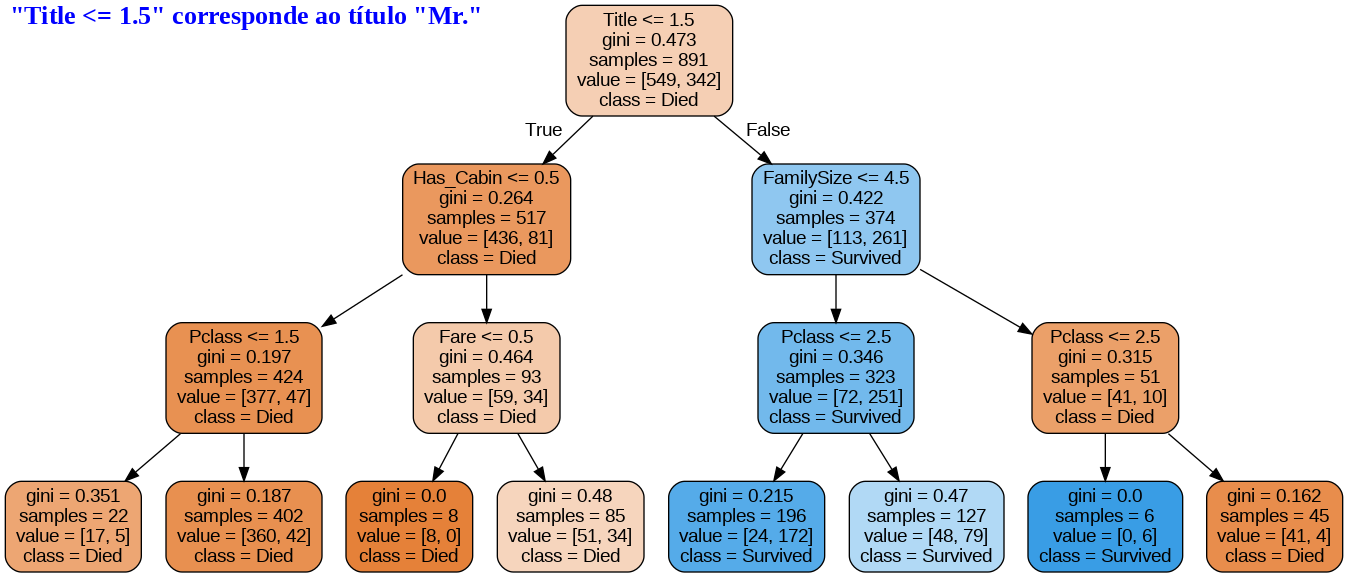

In [32]:
# Criando arrays Numpy dos dataframes de treino, teste e alvo (Survived) para alimentar nossos modelos
y_train = train['Survived']
x_train = train.drop(['Survived'], axis=1).values 
x_test = test.values

# Criando árvore de decisão com max_depth = 3
decision_tree = tree.DecisionTreeClassifier(max_depth = 3)
decision_tree.fit(x_train, y_train)

# Prevendo resultados para o conjunto de dados de teste
y_pred = decision_tree.predict(x_test)
submission = pd.DataFrame({
        "PassengerId": PassengerId,
        "Survived": y_pred
    })
submission.to_csv('submission.csv', index=False)

# Exportando o nosso modelo treinado como um arquivo .dot
with open("tree1.dot", 'w') as f:
     f = tree.export_graphviz(decision_tree,
                              out_file=f,
                              max_depth = 3,
                              impurity = True,
                              feature_names = list(train.drop(['Survived'], axis=1)),
                              class_names = ['Died', 'Survived'],
                              rounded = True,
                              filled= True )
        
#Convertendo .dot para .png para mostrar a imagem no notebook
check_call(['dot','-Tpng','tree1.dot','-o','tree1.png'])

# Anotando gráfico com PIL
img = Image.open("tree1.png")
draw = ImageDraw.Draw(img)
font = ImageFont.truetype('/usr/share/fonts/truetype/liberation/LiberationSerif-Bold.ttf', 26)
draw.text((10, 0), 
          '"Title <= 1.5" corresponde ao título "Mr."', 
          (0,0,255), 
          font=font) 
img.save('sample-out.png')
PImage("sample-out.png")

# Code to check available fonts and respective paths
# import matplotlib.font_manager
# matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

In [33]:
acc_decision_tree = round(decision_tree.score(x_train, y_train) * 100, 2)
acc_decision_tree

82.38

##Conclusões

O nosso modelo atingiu uma precisão de 82,38% em todo o conjunto de dados de treinamento. 

Vamos explicar o gráfico acima. 

- A primeira linha de cada nó (exceto os da última linha) mostra a condição de divisão na forma "feature <= value".

- A seguir, encontramos a Impureza de Gini do nó, já explicada neste kernel. 

- "Samples" é o número de entradas contidas no nó.

- "Value" mostra a distribuição de classe das amostras ([count non_survived, count survived]).

- "class" corresponde à classe predominante de cada nó, e é assim que nosso modelo classificará uma observação. A cor também representa a classe, a opacidade aumentando com a distribuição real das amostras.

Nosso modelo pode ser resumido em 4 regras simples:

- Se a nossa observação incluir o título "Mr", então a classificamos como não sobrevivente (todos os ramos no lado esquerdo da árvore levam a um nó laranja).

- Se ela não incluir o título "Mr" e o tamanho da família for 4 ou menos, então a classificamos como sobrevivente.

- Se ela não incluir o título "Mr", o tamanho da família for maior que 4 e a classe for 2 ou menos, então a classificamos como sobrevivente.

- Se ela não incluir o título "Mr", o tamanho da família for maior que 4 e a classe for maior que 2, então a classificamos como não sobrevivente.

Graças a essas regras, podemos inferir algumas informações sobre o naufrágio. Os "Misters" parecem ter honrado seus títulos e se sacrificado em favor de mulheres e homens com títulos mais exóticos como "Master" ou "Dr". Também podemos observar que famílias menores tiveram melhores chances de sobreviver, talvez porque famílias maiores tentaram ficar juntas ou procurar por membros desaparecidos e, portanto, não tiveram lugares sobrando nos botes salva-vidas. 

Finalmente, podemos observar que passageiros da 3ª classe também tiveram menos chances de sobreviver, então provavelmente os passageiros pertencentes a classes sociais mais altas foram privilegiados, ou simplesmente as cabines da 3ª classe podem ter ficado mais longe dos botes salva-vidas.